<a href="https://colab.research.google.com/github/tmsandford/M33_Matching/blob/main/HST_WISE_Match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install --upgrade pip
!pip install vaex
!pip install -Iv ipython==7.0.0
!pip install astroquery
!sudo pip install numpy --upgrade --ignore-installed
!pip install mpld3

##### MAKE SURE TO 'RESTART RUNTIME' #####

In [1]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
datadir = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [3]:
from astroquery.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u

Irsa.ROW_LIMIT = 100000

###Create a table of unWISE sources within the PHATTER footprint
wise = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.34,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.663,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.663,dec=30.85,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.34,dec=30.85,unit=(u.deg,u.deg),frame='icrs')])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: the ``irsa`` module has been moved to astroquery.ipac.irsa, please update your imports.
  """Entry point for launching an IPython kernel.


In [4]:
cut, = np.where(wise['primary'] == 1)
uw = wise[cut]

In [5]:
###Select only relevant columns and remove entries with no W1 flux measurement

uw1 = uw['unwise_objid','ra', 'dec', 'flux_1', 'flux_2']

uw2 = uw1.filled(fill_value=0)

unwise = uw2[uw2['flux_1'] != 0]


In [6]:
###Function to convert flux measurements to W1 magnitude

def unwise_to_mag(flux):
  mag = 22.5 - 2.5 * np.log10(flux)
  return mag

In [7]:
unwise['w1_mag'] = unwise_to_mag(unwise['flux_1'])

In [8]:
###Create a dataframe of PHATTER sources

phatter = vaex.open(datadir+'M33_full_matched.hdf5')
phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25) & (F160W_VEGA < 19)', name='IR_GST')

In [9]:
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']
phatter.select('(F110W_F160W > 0.5) & IR_GST', name='col_cut')

###F160W to H conversion (using color conversions from https://arxiv.org/pdf/1109.6893.pdf (Dalcanton, 2018))
def convert_to_JH(f110w,f160w):
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + convert_to_JH(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

j_mag, h_mag = HST_to_2MASS(phatter['F110W_VEGA'], phatter['F160W_VEGA'])

phatter['J_Mag'], phatter['H_Mag'], phatter['J_H'] = j_mag, h_mag, j_mag - h_mag


###Convert J-H to H-W1 using parameters from fit, then get W1 mags for PHATTER sources
m_fit, b_fit = 0.84805331, -0.35556147

phatter['H_W1'] = m_fit*phatter['J_H'] + b_fit

phatter['W1_Mag'] = phatter['H_Mag'] - phatter['H_W1']

###Convert W1 magnitude to flux and add column to data
def m_to_flux(mag):
  result = 10**((mag - 22.5) / (-2.5))
  return result

phatter['W1_Flux'] = m_to_flux(phatter['W1_Mag'])

In [10]:
ph_pandas = phatter.to_pandas_df(column_names=['RA', 'DEC', 'F110W_F160W', 'J_H', 'H_W1', 'F160W_VEGA', 'H_Mag', 'W1_Mag', 'W1_Flux'], selection='col_cut')
ph_data = vaex.from_pandas(ph_pandas)

/usr/local/lib/python3.7/dist-packages/vaex/arrow/numpy_dispatch.py:91: RuntimeWarning: overflow encountered in power
  result_data = op['op'](a_data, b_data)


In [11]:

unwise['index'] = np.arange(0, len(unwise), 1)

In [12]:
match_ids = np.asarray([-9999] * len(ph_data.RA.evaluate()))
#match_ids2 = np.asarray([-9999] * len(ph_data.RA.evaluate()))
distances = []
flux_fracs = []
total_flux_of_matches = np.asarray([-9999.999] * len(ph_data.RA.evaluate()))

for i,source in enumerate(unwise):                
  dist = np.sqrt( ((ph_data.RA.evaluate() - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 + 
               (ph_data.DEC.evaluate() - unwise['dec'][i])**2)
  matched, = np.where((dist <= 6/3600) & (match_ids == -9999))
  #matched2, = np.where((dist<= 6/3600) & (match_ids != -9999))
  
  if len(dist[matched]) != 0:
    ranked = np.argsort(ph_data.W1_Flux.evaluate()[matched])
    total_flux = np.sum(ph_data.W1_Flux.evaluate()[matched][ranked][:-6:-1])
    flux_frac = ph_data.W1_Flux.evaluate()[matched][ranked][:-6:-1] / total_flux

    distances.append(list(dist[matched][ranked][:-6:-1]))
    flux_fracs.append(list(flux_frac))
    match_ids[matched] = i
    total_flux_of_matches[matched] = total_flux.round(3)

  #elif len(dist[matched2]) != 0:
  #  match_ids2[matched2] = i

  


In [13]:
distances = [x for group in distances for x in group]

In [14]:
distances = np.array(distances)

In [15]:
flux_fractions = [x for group in flux_fracs for x in group]

In [16]:
flux_fractions = np.array(flux_fractions)

In [17]:
ph_data['WISE_match']= match_ids

In [18]:
matched, = np.where(ph_data.WISE_match.evaluate() != -9999)
ranked = np.argsort(ph_data.WISE_match.evaluate()[matched])
mr = ph_data.WISE_match.evaluate()[matched][ranked]
n = 6
first_n = np.unique(mr)[:n]

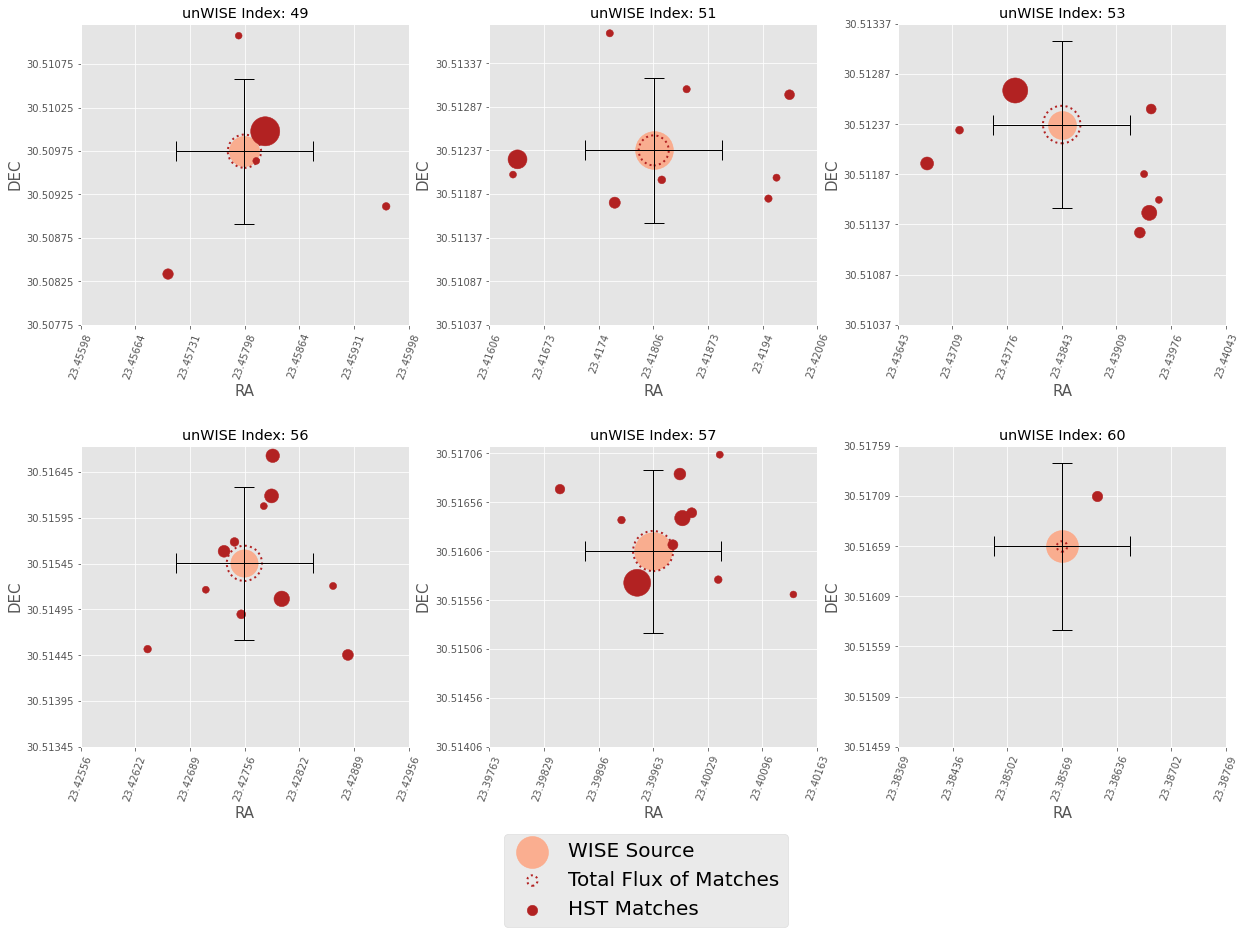

In [19]:
###First 6 matched unWISE sources

plt.style.use('ggplot')
fig, axs = plt.subplots(2,3)
fig.set_size_inches(18,12)
fig.tight_layout(pad=6, h_pad=10, w_pad=5)

ind = first_n

for i,ax in enumerate(axs.ravel()):
  j = ind[i]
  matches, = np.where((ph_data.WISE_match.evaluate() == j))
  match_flux = ph_data.W1_Flux.evaluate()[matches]
  total_flux = np.sum(ph_data.W1_Flux.evaluate()[matches])
  wise_flux = unwise['flux_1'][j]
  
  ax.scatter(unwise[j]['ra'], unwise[j]['dec'], s=wise_flux, c='lightsalmon', alpha=0.8, label='WISE Source')
  ax.scatter(unwise[j]['ra'], unwise[j]['dec'], s=total_flux, edgecolors='firebrick', 
             facecolors='none', marker='o', linestyle=':', linewidths=2, label='Total Flux of Matches')
  ax.errorbar(unwise[j]['ra'], unwise[j]['dec'], xerr=(3/3600), yerr=(3/3600), ecolor='black', elinewidth=1, capsize=10)
  ax.scatter(ph_data.RA.evaluate()[matches], ph_data.DEC.evaluate()[matches], s=match_flux, c='firebrick', label='HST Matches')
  
  x,y = unwise[j]['ra'], unwise[j]['dec']
  xticks, yticks = np.linspace(x-0.002, x+0.002, 7).round(5), np.linspace(y-0.002, y+0.001, 7).round(5)
  xlabels, ylabels = np.linspace(x-0.002, x+0.002, 7).round(5), np.linspace(y-0.002, y+0.001, 7).round(5)
  ax.set_xticks(xticks)
  ax.set_yticks(yticks)
  ax.set_xticklabels(xlabels, rotation=70)
  ax.set_yticklabels(ylabels)
  ax.set_xlabel('RA', fontsize=15)
  ax.set_ylabel('DEC', fontsize=15)
  ax.set_title('unWISE Index: ' + str(unwise['index'][j]))
  
labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc="upper center",
  bbox_to_anchor=(0.5, 0),
  bbox_transform=plt.gcf().transFigure,
  fontsize=20, markerscale=1, fancybox=True
);  
  

In [20]:
#double_match = np.where((ph_data.WISE_match.evaluate() != -9999) & (ph_data.WISE_match_2.evaluate() != -9999))
#close = np.array((ph_data.WISE_match.evaluate()[double_match], ph_data.WISE_match_2.evaluate()[double_match]))
#close

plt.style.use('ggplot')
fig, axs = plt.subplots(2,3)
fig.set_size_inches(18,9)
fig.tight_layout(h_pad=10, w_pad=5)

ind = close[::,:6]


for i,ax in enumerate(axs.ravel()):
  j = ind[0, i]
  k = ind[1, i]
  matches1, = np.where((ph_data.WISE_match.evaluate() == j))
  match_flux1 = ph_data.W1_Flux.evaluate()[matches1]
  total_flux1 = np.sum(ph_data.W1_Flux.evaluate()[matches1])

  matches2, = np.where((ph_data.WISE_match_2.evaluate() == k))
  match_flux2 = ph_data.W1_Flux.evaluate()[matches2]
  total_flux2 = np.sum(ph_data.W1_Flux.evaluate()[matches2])
  
  ax.scatter(unwise[j]['ra'], unwise[j]['dec'], marker='o', s=unwise[j]['flux_2'], facecolors='none', edgecolors='firebrick', linewidths=2)
  ax.scatter(unwise[j]['ra'], unwise[j]['dec'], c='firebrick')
  ax.scatter(ph_data.RA.evaluate()[matches1], ph_data.DEC.evaluate()[matches1], 
             s=match_flux1, c='orange', label=('HST Matches - Source '+ str(unwise['index'][j])))

  ax.scatter(unwise[k]['ra'], unwise[k]['dec'],  marker='o', s=unwise[k]['flux_2'], facecolors='none', edgecolors='steelblue', linewidths=2)
  ax.scatter(unwise[k]['ra'], unwise[k]['dec'],  c='steelblue')
  ax.scatter(ph_data.RA.evaluate()[matches2], ph_data.DEC.evaluate()[matches2], 
             s=match_flux2, c='powderblue', label=('HST Matches - Source ' + str(unwise['index'][k])), alpha=0.6)
  
  x,y = unwise[j]['ra'], unwise[j]['dec']
  xticks, yticks = np.linspace(x-0.002, x+0.002, 7).round(5), np.linspace(y-0.002, y+0.002, 7).round(5)
  xlabels, ylabels = np.linspace(x-0.002, x+0.002, 7).round(5), np.linspace(y-0.002, y+0.002, 7).round(5)
  ax.set_xticks(xticks)
  ax.set_yticks(yticks)
  ax.set_xticklabels(xlabels, rotation=70)
  ax.set_yticklabels(ylabels)
  ax.set_xlabel('RA', fontsize=15)
  ax.set_ylabel('DEC', fontsize=15)
  ax.set_title('unWISE Indices: ' + str(unwise['index'][j]) + ' & ' + str(unwise['index'][k]))
  ax.legend(loc='best', fancybox=True, shadow=True, markerscale=0.3);

In [21]:
fractional_flux = (ph_data.W1_Flux.evaluate() / total_flux_of_matches)

In [22]:
not_real, = np.where(fractional_flux < 0.0)

In [23]:
fractional_flux[not_real] = 0.0

In [24]:
ones, = np.where(fractional_flux > 0.999)
match_index = np.unique(ph_data.WISE_match.evaluate()[ones])

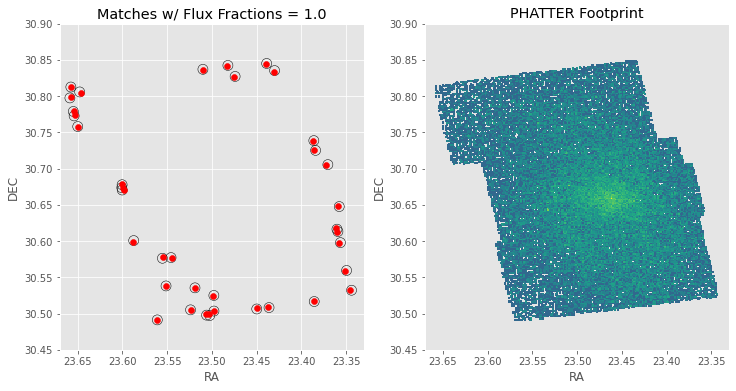

In [25]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
plt.style.use('ggplot')

ra, dec = ph_data.RA.evaluate()[ones], ph_data.DEC.evaluate()[ones]
wra, wdec = unwise['ra'][match_index], unwise['dec'][match_index]

ax[0].scatter(wra, wdec, edgecolors='black', marker='o', s=100, facecolor='none');
ax[0].scatter(ra, dec, c='red');
ax[0].set_title('Matches w/ Flux Fractions = 1.0')
ax[0].set_xlim(23.67, 23.33)
ax[0].set_ylim(30.45, 30.9)
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')

ax[1].hist2d(ph_data.RA.evaluate(), ph_data.DEC.evaluate(), bins=200, norm=mpl.colors.LogNorm(vmin=0.1,vmax=1e2), cmap='viridis');
ax[1].set_title('PHATTER Footprint');
ax[1].set_xlim(23.67, 23.33)
ax[1].set_ylim(30.45, 30.9)
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC');

In [26]:
phatter.select('(H_W1 == H_W1) & IR_GST', name='real')

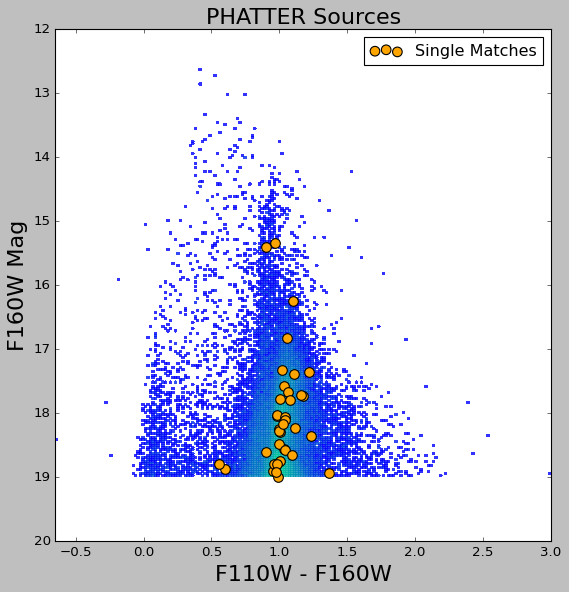

In [27]:
plt.style.use('ggplot')
x,y = phatter.F110W_F160W.evaluate(selection='real'), phatter.F160W_VEGA.evaluate(selection='real')
x1,y1 = ph_data.F110W_F160W.evaluate()[ones], ph_data.F160W_VEGA.evaluate(0)[ones]

plt.style.use('classic')
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)
ax.hist2d(x,y,bins=200, cmap='winter', norm=mpl.colors.LogNorm(vmin=1,vmax=1e3), alpha=0.8, label='HST')
ax.scatter(x1,y1, c='orange', s=75, marker='o', label='Single Matches')

ax.set_ylim(20,12)
ax.set_xlabel('F110W - F160W', fontsize=20)
ax.set_ylabel('F160W Mag', fontsize=20)
ax.set_title('PHATTER Sources', fontsize=20);
#ax.legend(loc='best', fancybox=True, markerscale=1);
ax.legend();

In [28]:
ph_ra_shift = ph_data.RA.evaluate() + (18/3600)

In [29]:
match_ids_shift = np.asarray([-9999] * len(ph_data.RA.evaluate()))
#match_ids2 = np.asarray([-9999] * len(ph_data.RA.evaluate()))
distances_shift = []
flux_fracs_shift = []
total_flux_shift = np.asarray([-9999.999] * len(ph_data.RA.evaluate()))

for i,source in enumerate(unwise):                
  dist = np.sqrt( ((ph_ra_shift - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 + 
               (ph_data.DEC.evaluate() - unwise['dec'][i])**2)
  matched, = np.where((dist <= 6/3600) & (match_ids == -9999))
  #matched2, = np.where((dist<= 6/3600) & (match_ids != -9999))
  
  if len(dist[matched]) != 0:
    ranked = np.argsort(ph_data.W1_Flux.evaluate()[matched])
    total_flux = np.sum(ph_data.W1_Flux.evaluate()[matched][ranked][:-6:-1])
    flux_frac = ph_data.W1_Flux.evaluate()[matched][ranked][:-6:-1] / total_flux

    distances_shift.append(list(dist[matched][ranked][:-6:-1]))
    flux_fracs_shift.append(list(flux_frac))
    match_ids_shift[matched] = i
    total_flux_shift[matched] = total_flux.round(3)

  #elif len(dist[matched2]) != 0:
  #  match_ids2[matched2] = i

In [30]:
distances_shift = [x for group in distances_shift for x in group]

In [31]:
distances_shift = np.array(distances_shift)

In [32]:
flux_fracs_shift = [x for group in flux_fracs_shift for x in group]

In [33]:
flux_fracs_shift = np.array(flux_fracs_shift)

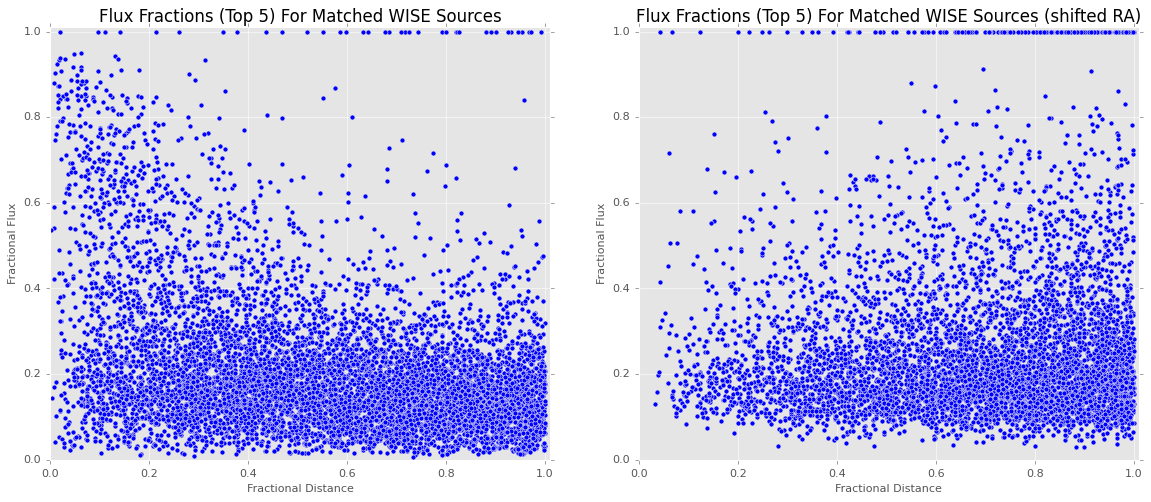

In [34]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,2)
fig.tight_layout()
fig.set_size_inches(15,6)

x = distances / (6/3600)
y = flux_fractions

xshift = distances_shift / (6/3600)
yshift = flux_fracs_shift

ax[0].scatter(x, y)
ax[0].set_ylabel('Fractional Flux', fontsize=10);
ax[0].set_xlabel('Fractional Distance', fontsize=10);
ax[0].set_title('Flux Fractions (Top 5) For Matched WISE Sources', fontsize=15);
ax[0].set_xlim(0,1.01)
ax[0].set_ylim(0,1.01)

ax[1].scatter(xshift, yshift)
ax[1].set_ylabel('Fractional Flux', fontsize=10);
ax[1].set_xlabel('Fractional Distance', fontsize=10);
ax[1].set_title('Flux Fractions (Top 5) For Matched WISE Sources (shifted RA)', fontsize=15);
ax[1].set_xlim(0,1.01)
ax[1].set_ylim(0,1.01);